**Table of contents**<a id='toc0_'></a>    
- [ Movies revenue prediction](#toc1_)    
- [Импорт библиотек и данных](#toc2_)    
- [Изучение структуры данных](#toc3_)    
- [Подготовка данных](#toc4_)    
  - [Индексы (index, id, imdb_id)](#toc4_1_)    
  - [Время релиза (release_date)](#toc4_2_)    
  - [Выручка и бюджет (revenue_adj, budget_adj, revenue, budget)](#toc4_3_)    
  - [Оценки зрителей (popularity, vote_count, vote_average)](#toc4_4_)    
  - [Текстовые описания фильма (homepage, tagline, overview, keywords, genres, cast, director, production_companies)](#toc4_5_)    
- [Исследовательский анализ](#toc5_)    
- [Создание моделей](#toc6_)    
  - [Линейные модели](#toc6_1_)    
  - [Модели решающего дерева и случайного леса](#toc6_2_)    
  - [Модели градиентного бустинга Catboost и LGBM](#toc6_3_)    
  - [Результаты моделей получены](#toc6_4_)    
- [Обучение и тест лучшей модели](#toc7_)    
- [Результаты](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[ Movies revenue prediction](#toc0_)

**Описание проблемы**

<p><img style="float:right; margin:20px; padding:20px; max-height:400px" src="https://images.pexels.com/photos/8263316/pexels-photo-8263316.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"></p>
<p style="text-align:justify;">
    
К вам обращается компания, управляющая кинотеатрами. Компания хочет предсказать, насколько успешным будет фильм, еще до его выхода. Компания хочет использовать эти прогнозы как часть планирования расписания фильмов. Компания предоставляет вам набор данных и просит вас создать модель машинного обучения, чтобы помочь им.

**Цель**

Создать ML модель, которая будет предсказывать полученную прибыль в процессе показа фильма. Метрика - RMSE. 

**Задачи**

1. Осмотреть и подготовить данные
2. Провести исследовательский анализ данных
3. Выбрать актуальные для модели признаки, выбрать актуальный временной период для обучения модели, преобразовать признаки
4. Обучить различные модели на тренировочных данных
5. Выбрать лучшую модель и провести итоговый тест
6. Сделать общие выводы

**Подход к решению**

1. Осмотреть данные целиком (явные дубликаты, пропуски, размеры, id, типы)
2. Подготовить каждый признак:
    1. Разбить признаки на группы
    2. Убрать признаки не имеющие отношения к будущей модели
    3. Заполнить пропуски
    4. Преобразовать признаки (допустим перекодировать в бинарные, можно ли категоризировать и т.д.) и лучше это сделать функциями
3. Найти корреляцию в данных с целевым признаком, построить графики объясняющие важность признаков и зависимости, найти актуальный период
4. Исследую модели линейной регрессии (с регуляризацией и без), ансамблевые модели из sklearn, и градиентный бустинг (кэтбуст, LGBM)
7. Каждую модель буду обучать с небольшим подбором гиперпараметров, и собирать получившиеся метрики, поэтому лучше написать отдельную функцию универсальную для проверки и сбора метрик.
8. Соберу метрики в таблицу и найду наилучшую модель. Обучу её с широким подбором гиперпараметров. Потом тест модели и сделаю в графическом виде результаты модели. 
9. Соберу результат в графическом виде


**Данные**

Источник данных - (https://www.kaggle.com/datasets/juzershakir/tmdb-movies-dataset)

# <a id='toc2_'></a>[Импорт библиотек и данных](#toc0_)

In [1]:
# Для каггла
#!pip install tqdm

In [2]:
# Pandas
import pandas as pd

# Seaborn
import seaborn as sns

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet,
    Ridge
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.ensemble import RandomForestRegressor

# LightGMB
from lightgbm import LGBMRegressor

# Catboost
from catboost import CatBoostRegressor

# Time
import time

# tqdm
from tqdm import notebook
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
data = pd.read_csv(r"C:\project_data\movies\tmdb_movies_data.csv")

# <a id='toc3_'></a>[Изучение структуры данных](#toc0_)

<font color='orange'>**Осмотр, размеры, пропуски, дубликаты**</font>

In [4]:
display(data.head(3))

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.5,2015,137999939.3,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.1,2015,137999939.3,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.3,2015,101199955.5,2.716190e+08


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [6]:
data.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [7]:
data.duplicated().value_counts()

False    10865
True         1
dtype: int64

In [8]:
data = data.drop_duplicates()

In [9]:
print(data['release_date'].min())
print(data['release_date'].max())

1/1/1960
9/9/2015


<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font color='green'>**Вывод - Общий анализ:**</font>

1. Пропуски есть
2. Один явный дубликат
3. 21 столбец, 10800 строк
4. Временной период от 1960 по 2015 год

# <a id='toc4_'></a>[Подготовка данных](#toc0_)

## <a id='toc4_1_'></a>[Индексы (index, id, imdb_id)](#toc0_)

In [10]:
# Порядок индексов
display(data[['id', 'release_date']].sort_values(by='id').head(4))

,id,release_date
8088,5,12/25/1995
10249,6,10/15/1993
1329,11,3/20/1977
4955,12,5/30/2003


Нужно сделать новые индексы, так как пропуски в imdb id, а id из данных начинается с 5 и не идёт по порядку

Удалю столбцы id и imdb_id, отсортирую по времени и переделаю индекс

In [11]:
# Удаляю старые id
data = data.drop(['id', 'imdb_id'], axis=1)

In [12]:
# Новый индекс сортированный по дате релиза
data = data.sort_values(by='release_date').reset_index(drop=True)

## <a id='toc4_2_'></a>[Время релиза (release_date)](#toc0_)

<font color='orange' font size=4>**Переведу в Datetime и добавлю признаки дня/недели**</font>

In [13]:
# data['release_date'][data['original_title']=='Jurassic World']

In [14]:
# Перевожу в формат datetime
data['release_date'] = pd.to_datetime(data['release_date'], format='%m/%d/%Y')

In [15]:
# data['release_date'][data['original_title']=='Jurassic World']

In [16]:
# Добавлю в датасет признаки для дня/недели/квартала

data['release_day'] = data['release_date'].dt.day
data['release_month'] = data['release_date'].dt.month
data['release_quarter'] = data['release_date'].dt.quarter
data['release_day_of_week'] = data['release_date'].dt.dayofweek
data['release_day_of_year'] = data['release_date'].dt.day_of_year

## <a id='toc4_3_'></a>[Выручка и бюджет (revenue_adj, budget_adj, revenue, budget)](#toc0_)

<font color='orange' font size=4>**Целевой признак для работы**</font> - выручка с поправкой на инфляцию, так как выручка и продажи билетов влияют на прибыль кинотеатров, вычитать из нее затраты на производоство фильма неправильно.

In [17]:
data[['revenue_adj', 'budget_adj', 'revenue', 'budget']].describe()

,revenue_adj,budget_adj,revenue,budget
count,1.086500e+04,1.086500e+04,1.086500e+04,1.086500e+04
mean,5.136900e+07,1.754989e+07,3.982690e+07,1.462429e+07
std,1.446383e+08,3.430753e+07,1.170083e+08,3.091428e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.370173e+07,2.085325e+07,2.400000e+07,1.500000e+07
max,2.827124e+09,4.250000e+08,2.781506e+09,4.250000e+08


In [18]:
# Убираю столбцы с бюджетом и выручкой без поправки на инфляцию, они менее актуальны, чем с поправкой
data = data.drop(['revenue', 'budget'], axis=1)

In [19]:
data[['original_title', 'release_date']][data['revenue_adj'] == 0].shape

(6016, 2)

Большая часть данных не содержит целевого признака, на данный момент оставлю как есть (нужно для подсчёта фильмов), а перед обучением удалю строки с нулями

Максимумы адекватны, выбросов нет

## <a id='toc4_4_'></a>[Оценки зрителей (popularity, vote_count, vote_average)](#toc0_)

In [20]:
data[['popularity', 'vote_count', 'vote_average']].describe()

,popularity,vote_count,vote_average
count,10865.000000,10865.000000,10865.000000
mean,0.646446,217.399632,5.975012
std,1.000231,575.644627,0.935138
min,0.000065,10.000000,1.500000
25%,0.207575,17.000000,5.400000
50%,0.383831,38.000000,6.000000
75%,0.713857,146.000000,6.600000
max,32.985763,9767.000000,9.200000


Значения выглядят адекватными и без выбросов

## <a id='toc4_5_'></a>[Текстовые описания фильма (homepage, tagline, overview, keywords, genres, cast, director, production_companies)](#toc0_)

<font color='orange' font size=4>**homepage, tagline, overview**</font>

Данные о сайте фильма и описание фильма - удалю, для анализа они не нужны. Хотя описание фильма (overview) можно было бы использовать, но это сильно увеличит размеры данных и вряд-ли даст значимый прирост в метрике. Переделаю homepage - в значения "есть или нет"

In [21]:
# удаляю лишние
data = data.drop(['tagline', 'overview'], axis=1)

In [22]:
# есть ли страница фильма в интернете
data['homepage'] = data['homepage'].notnull().astype(int)

<font color='orange' font size=4>**keywords, genres, cast, director, production_companies**</font>

- Все эти признаки могут помочь модели, их нужно перекодировать в бинарные признаки (кодировка в функции ниже)
- Добавлю количество актеров отмеченные в cast в отдельный столбец

In [23]:
# Списки признаков
features_list_OHE = ['keywords', 'genres',
                     'cast', 'director', 'production_companies']
features_numerical = ['popularity', 'runtime', 'vote_count', 'budget_adj']

In [24]:
# Заполню пропуски заглушки типо no_info
data['keywords'] = data['keywords'].fillna('no_keywords')
data['genres'] = data['genres'].fillna('no_genres')
data['cast'] = data['cast'].fillna('no_cast')
data['director'] = data['director'].fillna('no_director')
data['production_companies'] = data['production_companies'].fillna(
    'no_production_companies')

In [25]:
# Добавлю признак "cast_num" содержащий количество актёров
data['cast_num'] = data['cast'].str.count('\|') + 1
data['cast_num'] = data['cast_num'].fillna(0).astype(int)
# print(data[['cast', 'cast_num']].head(20))

Перевожу строки в столбцах в списки и в нижний регистр

In [26]:
for feature in features_list_OHE:
    data[feature] = data[feature].str.lower().str.split('|')

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="5"><b>Важная часть!</b></font>
   
Ниже в ячейке показно количество уникальных значений для столбцов, и если их бинарно классифицировать, таблица будет довольно большой для вычислений. Я пробовал сделать классификацию каждого значения, но модель становилась хуже
</div>

In [27]:
for feature in features_list_OHE:
    print(str(feature), data[feature].explode().nunique())

keywords 7879
genres 21
cast 19026
director 5363
production_companies 7862


<font color='orange' font size=4>**Сделаю функцию, которая которая кодирует признаки (в ней можно выбрать разные параметры).**</font>


Суть работы: кодирует признаки по выбору. Пример работы: выбираю год и top_n = 50. Функция находит топ-50 (по выручке) лучших актеров, режиссеров, ключевых слов, компаний. И классифицирует их. Жарны классифицируются полностью всегда.

Параметры:
1. data - датасет который будет кодирован
2. years - год с которого начинаются данные. По дефолту стоит год 1960 (он включает все данные)
3. top_n - количество классификаций для топ по прибыльности признаков. По дефолту = 100


In [28]:
def feature_encoding(data, years=1960, top_n=100):

    # Список столбцов для работы
    features_list = ['genres', 'director',
                     'production_companies', 'keywords', 'cast']

    # Оставляю только необходимый временной период
    data = data[data['release_year'] >= years]

    # Удаление строк в которох нет данных о бюджете или выручке
    data = data[data['revenue_adj'] != 0]
    data = data[data['budget_adj'] != 0]

    # Классифицирую все жанры
    mlb = MultiLabelBinarizer()
    binary_features = pd.DataFrame(mlb.fit_transform(data['genres']),
                                   columns=mlb.classes_,
                                   index=data.index)
    binary_features = binary_features.add_suffix('_' + 'genres')
    data = pd.concat([data, binary_features], axis=1)

    # Классифицирую top-n актеров (лучших по сборам)
    # Создание нового DataFrame с актерами и суммарной выручкой
    actor_revenue = data.explode('cast').groupby(
        'cast')['revenue_adj'].sum().reset_index()
    # Выбор top-n актеров по суммарной выручке
    top_actors = actor_revenue.nlargest(top_n, 'revenue_adj')
    # Создание столбцов классификации для каждого актера
    for actor in top_actors['cast']:
        data['actor_' +
             actor] = data['cast'].apply(lambda x: 1 if actor in x else 0)

    # Классифицирую N режисеров (лучших по сборам)
    data['director'] = data['director'].apply(
        lambda x: x[0] if isinstance(x, list) else x)
    director_revenue = data.groupby(
        'director')['revenue_adj'].sum().reset_index()
    top_directors = director_revenue.nlargest(top_n, 'revenue_adj')
    for director in top_directors['director']:
        data['director_' +
             director] = data['director'].apply(lambda x: 1 if x == director else 0)

    # Классифицирую top-n production_companies (лучших по сборам)
    # Создание нового DataFrame с production_companies и суммарной выручкой
    production_companies_revenue = data.explode('production_companies').groupby(
        'production_companies')['revenue_adj'].sum().reset_index()
    # Выбор top-n production_companies по суммарной выручке
    top_production_companies = production_companies_revenue.nlargest(
        top_n, 'revenue_adj')
    # Создание столбцов классификации для каждого production_companies
    for production_companie in top_production_companies['production_companies']:
        data['production_companie_' + production_companie] = data['production_companies'].apply(
            lambda x: 1 if production_companie in x else 0)

    # Классифицирую top-n keywords (лучших по сборам)
    # Создание нового DataFrame с keywords и суммарной выручкой
    keywords_revenue = data.explode('keywords').groupby(
        'keywords')['revenue_adj'].sum().reset_index()
    # Выбор top-n keywords по суммарной выручке
    top_keywords = keywords_revenue.nlargest(top_n, 'revenue_adj')
    # Создание столбцов классификации для каждого keywords
    for keyword in top_keywords['keywords']:
        data['keyword_' +
             keyword] = data['keywords'].apply(lambda x: 1 if keyword in x else 0)

    # Удаление столбцов с признаками которые были обработаны
    data = data.drop(features_list, axis=1)
    data = data.drop(['original_title', 'release_date'], axis=1)

    # print(top_keywords)
    return data

In [29]:
# Функция для разделения датасета на трейн/тест + дополнительно возможность масштабирования

def data_split(data, scaling=False):

    target = data['revenue_adj']
    features = data.drop(['revenue_adj'], axis=1)
    feature_list_all = features.columns

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=12345)

    if scaling:
        # Создаю скейлер
        scaler = StandardScaler()
        # Обучаю скейлер
        scaler.fit(X_train)
        # Трансформирую данные
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, feature_list_all

# <a id='toc5_'></a>[Исследовательский анализ](#toc0_)

Я буду рассматривать этот анализ только в отношении построения модели, не буду делать что-то вроде топ-10 режиссеров, самые крупные фильмы и т.д.

- Создаю новую копию датасета для EDA
- Перевожу нулевые значения бюджета и выручки в nan
- Делю выручку на миллион, для удобства презентации

In [30]:
EDA_data = data.copy()
EDA_data['revenue_adj'] /= 1000000
EDA_data['budget_adj'] = EDA_data['budget_adj'].replace(0, np.nan)
EDA_data['revenue_adj'] = EDA_data['revenue_adj'].replace(0, np.nan)

<font color='orange' font size=4>Сколько всего фильмов выходит в год?</font>

<AxesSubplot:xlabel='release_year', ylabel='Count'>

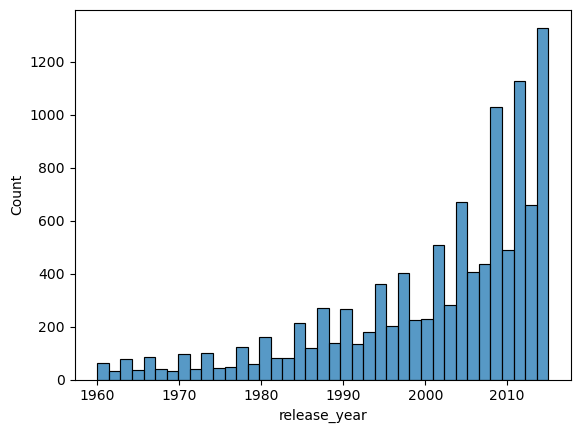

In [31]:
sns.histplot(EDA_data['release_year'])

<font color='orange'>**Ищу актуальный период для данных**</font>

Два графика вместе, средние значение выручки и сумарное (+ доверительный интервал).

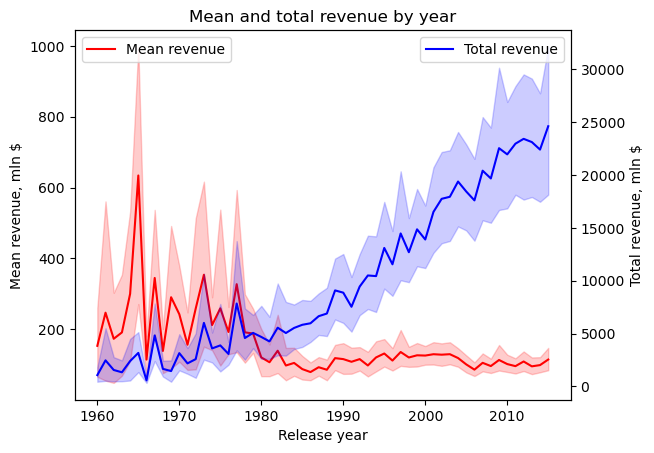

In [32]:
# Создание объекта Axes
fig, ax1 = plt.subplots()

# Первый график
sns.lineplot(data=EDA_data, x='release_year', y='revenue_adj',
             color='red', estimator='mean', ax=ax1, label='Mean revenue')
ax1.set_ylabel('Mean revenue, mln $')

# Создание второй оси y
ax2 = ax1.twinx()

# Второй график
sns.lineplot(data=EDA_data, x='release_year', y='revenue_adj',
             color='blue', estimator='sum', ax=ax2, label='Total revenue')
ax2.set_ylabel('Total revenue, mln $')

ax1.set_xlabel('Release year')
ax1.set_title('Mean and total revenue by year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Показать график
plt.show()

Выберу данные с 1985 года

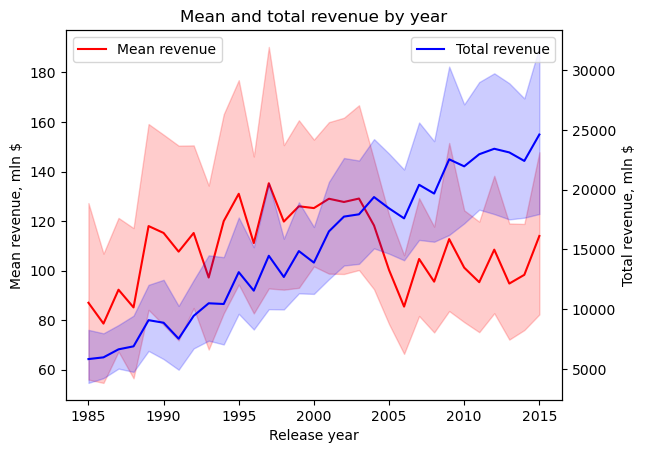

In [33]:
# Установка периода
start_year = 1985

# Отбор данных в указанном периоде
period_data = EDA_data[EDA_data['release_year'] >= start_year]

# Создание объекта Axes
fig, ax1 = plt.subplots()

# Первый график
sns.lineplot(data=period_data, x='release_year', y='revenue_adj',
             color='red', estimator='mean', ax=ax1, label='Mean revenue')
ax1.set_ylabel('Mean revenue, mln $')

# Создание второй оси y
ax2 = ax1.twinx()

# Второй график
sns.lineplot(data=period_data, x='release_year', y='revenue_adj',
             color='blue', estimator='sum', ax=ax2, label='Total revenue')
ax2.set_ylabel('Total revenue, mln $')

# Настройка заголовка и меток осей
ax1.set_xlabel('Release year')
ax1.set_title('Mean and total revenue by year')

# Отображение легенды
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Показать график
plt.show()

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font color='green'>**Период - вывод**</font>

- Данные до ~1985 года не имеют четкого тренда и имеют очень большой разброс. Для построения модели они не актуальны и даже вредны
- Линейный тренд на суммарную выручку прослеживается с 1985 года
- А вот данные про среднюю выручку более-менее постоянны примерно с 2005 года
- Возможно стоит попробовать три разных периода данных (с 1985 года, с 2000 года, с 2005 года) при валидации моделей

# <a id='toc6_'></a>[Создание моделей](#toc0_)

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="5"><b>Важная часть!</b></font>
   
Ниже в ячейке вызов функцит которая готовит данные для обучения и теста. Я в ней эксперементировал с раскрытием признаков. В ней можно менять параметры для подготовки признаков
    
</div>

In [35]:
new_data = feature_encoding(data, years=2000, top_n=100)
X_train, X_test, y_train, y_test, feature_list_all = data_split(
    new_data, scaling=False)
print('Размеры всех данных', new_data.shape)
print('Размеры тренировочных данных', X_train.shape)
print('Размеры тестовых данных', X_test.shape)

Размеры всех данных (2500, 433)
Размеры тренировочных данных (2000, 432)
Размеры тестовых данных (500, 432)


<font color='orange' font size=4>**Функция для обучения моделей и сбора метрик моделей**</font>
- model_eval(model_name, model, parameters)
- Кросс-валидация через грид-серч
- Выбрал разные метрики, но для интереса, главная метрика для оценки - RMSE
- Сохраняет метрики в словарь results (потом из него датафрейм построю)
- Сохраняет лучшие гиперпараметры в словарь best_parameters

In [37]:
# В эти переменные я собираю метрики
results = {}
best_parameters = {}


def model_eval(model_name, model, parameters):

    # Параметры для скоринга и кросс-валидации
    scoring = {'RMSE': 'neg_root_mean_squared_error', "R2": "r2",
               'MAE': 'neg_mean_absolute_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

    # Гридсерч
    grid_search_model = GridSearchCV(
        model, parameters, cv=4, scoring=scoring, n_jobs=-1, refit="RMSE")
    grid_search_model.fit(X_train, y_train)

    # Сохраняю метрики лучшей модели
    RMSE = -grid_search_model.best_score_
    MAE = - \
        grid_search_model.cv_results_[
            'mean_test_MAE'][grid_search_model.best_index_]
    R2 = grid_search_model.cv_results_[
        'mean_test_R2'][grid_search_model.best_index_]
    MAPE = - \
        grid_search_model.cv_results_[
            'mean_test_MAPE'][grid_search_model.best_index_]

    """     # Вывод на экран метрик
    print('Метрики для модели', model_name)
    print('RMSE =', RMSE)
    print('MAE =', MAE)
    print('R2 =', R2)
    print('MAPE =', MAPE)
    print('Best parameters', grid_search_model.best_params_) """

    # Время предсказания
    start_time = time.time()
    grid_search_model.predict(X_test)
    predict_time = time.time() - start_time

    # Сохраняю в общую таблицу метрики для модели
    results[model_name] = [RMSE, MAE, R2, MAPE, predict_time]
    best_parameters[model_name] = grid_search_model.best_params_
    return None

<font color='orange'>**Dummy модель**</font>
- Сделал dummy модель для дальнейшего сравнения с ней. Но очень большой разброс получится (если брать средние сборы фильма), вообще неинформативно для оценки либо сравнения

In [38]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
prediction_dummy = dummy_regr.predict(X_test)
dummy_rmse = mean_squared_error(y_test, prediction_dummy)**0.5
print("RMSE (test) =", dummy_rmse)

RMSE (test) = 191100777.04564047


## <a id='toc6_1_'></a>[Линейные модели](#toc0_)

<font color='orange'>**Модель линейной регрессии**</font>

Модель построил без функции (model_eval(model_name, model, parameters)), из-за отсутствия гиперпараметров

In [39]:
split_for_LR = X_train.shape[0]-X_test.shape[0]

model = LinearRegression()
model.fit(X_train[:split_for_LR], y_train[:split_for_LR])
y_pred = model.predict(X_train[split_for_LR:])
y_true = y_train[split_for_LR:]

# Метрики
RMSE_l = mean_squared_error(y_pred, y_true)**0.5
MAE_l = mean_absolute_error(y_pred, y_true)
R2_l = r2_score(y_pred, y_true)
MAPE_l = mean_absolute_percentage_error(y_pred, y_true)

# Время предсказания
start_time = time.time()
model.predict(X_test)
predict_time = time.time() - start_time

""" print("RMSE =", RMSE_l)
print('MAE =', MAE_l)
print('R2 =', R2_l)
print('MAPE =', R2_l) """

# Сохраняю в общие результаты
results['LinearRegression'] = [RMSE_l, MAE_l, R2_l, MAPE_l, predict_time]

RMSE = 290451470559.61206
MAE = 22855665525.629425
R2 = -0.005817184953645027
MAPE = -0.005817184953645027


<font color='orange'>**Модель ElasticNet**</font>


In [40]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval('ElasticNet', ElasticNet(random_state=12345), parameters)

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.572e+18, tolerance: 8.193e+15
  model = cd_fast.enet_coordinate_descent(



<font color='orange'>**Модель Lasso**</font>


In [41]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval('Lasso', Lasso(random_state=12345), parameters)

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.027e+18, tolerance: 8.193e+15
  model = cd_fast.enet_coordinate_descent(


<font color='orange'>**Модель Ridge**</font>

In [42]:
parameters = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
model_eval('Ridge', Ridge(random_state=12345), parameters)

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.74311e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## <a id='toc6_2_'></a>[Модели решающего дерева и случайного леса](#toc0_)

<font color='orange'>**Модель решающего дерева**</font>

In [43]:
parameters = {"splitter": ["best", "random"],
              "max_depth": [1, 3, 5, 7, 9, 11, 12],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "min_weight_fraction_leaf": [0.1, 0.2, 0.3, 0.4, 0.5],
              "max_features": ["auto", "log2", "sqrt", None]}
model_eval('Решающее дерево',
           DecisionTreeRegressor(random_state=12345), parameters)

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


<font color='orange'>**Модель случайного леса**</font>

In [44]:
parameters = {"n_estimators": [1, 10, 100, 500],
              "max_depth": [2, 4, 6, 8, 10]}
model_eval('Случайный лес',
           RandomForestRegressor(random_state=12345), parameters)

## <a id='toc6_3_'></a>[Модели градиентного бустинга Catboost и LGBM](#toc0_)

<font color='orange'>**Модель LGBM**</font>

Пришлось отказаться от этой модели из-за проблем с кодировками текста после кодировки признаков

ОШИБКА:
lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.

In [45]:
""" parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]}
model_eval('LGBMRegressor', LGBMRegressor(), parameters) """

" parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]}\nmodel_eval('LGBMRegressor', LGBMRegressor(), parameters) "

<font color='orange'>**Модель Catboost**</font>

In [46]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5]}
model_eval('Catboost', CatBoostRegressor(
    verbose=200), parameters)

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 191818844.9824443	total: 61.3ms	remaining: 1m 1s
200:	learn: 52385896.2338034	total: 2.28s	remaining: 9.05s
400:	learn: 36705000.8010439	total: 3.49s	remaining: 5.22s
600:	learn: 29228655.0416943	total: 4.81s	remaining: 3.19s
800:	learn: 23986277.4447964	total: 6.01s	remaining: 1.49s
999:	learn: 20013693.1890034	total: 7.25s	remaining: 0us


## <a id='toc6_4_'></a>[Результаты моделей получены](#toc0_)

<font color='orange'>**Сравнение моделей**</font>

In [47]:
results_df = pd.DataFrame(results, index=[
                          'RMSE, в млн. $', 'MAE, в млн. $', 'R2', 'MAPE, количество раз', 'Predict_time'])
results_df.loc['RMSE, в млн. $'] /= 1000000
results_df.loc['MAE, в млн. $'] /= 1000000
results_df.loc['MAPE, количество раз'] /= 100

In [48]:
pd.options.display.float_format = '{:.3f}'.format
display(results_df.transpose().sort_values(by='RMSE, в млн. $'))

,"RMSE, в млн. $","MAE, в млн. $",R2,"MAPE, количество раз",Predict_time
Catboost,97.429,51.162,0.764,108.374,0.042
Случайный лес,101.345,52.092,0.747,48.045,0.306
Ridge,103.328,59.964,0.735,191.603,0.014
ElasticNet,103.414,60.291,0.735,202.722,0.020
Решающее дерево,144.158,74.305,0.484,55.898,0.011
Lasso,148.691,76.215,0.413,692.861,0.035
LinearRegression,290451.471,22855.666,-0.006,0.025,0.028


<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font color='orange'>**Вывод - Сравнение моделей**</font>

- Кэтбуст лучший по RMSE, R2. Выбираю его для обучения и тестирования дальнейшего
- Модели с L1 регуляризацией (Ridge, ElasticNet) лучше, чем только с L2 (Lasso) и сравнимы с Catboost
- Модель LinearRegression значительно отличается от других моделей из-за отсутствия масштабирования в данных.
- На втором месте - случайный лес, но скорость предсказания и долгое обучения сильно уступает другим моделям

<font color='orange'>**Подбор гиперпараметров для кэтбуста под разные данные**</font>
- В цикле подбираю гиперпараметры, top-n признаков и год начала данных
- В результате получу таблицу с метриками и названием модели+данных в формате Catboost_{год}_{top_n}

In [49]:
years = [1985, 2000, 2005]
top_n_features = [10, 25, 50, 100, 200]
results = {}

parameters = {
    # Скорость обучения
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'l2_leaf_reg': [1, 3, 5]  # Регуляризация L2
}

for year in notebook.tqdm(years):
    for number in notebook.tqdm(top_n_features):
        new_data = feature_encoding(data, years=year, top_n=number)
        X_train, X_test, y_train, y_test, feature_list_all = data_split(
            new_data, scaling=False)
        model_eval(('Catboost'+'_' + str(year) + '_' + str(number)), CatBoostRegressor(
            logging_level='Silent'), parameters)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: i

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: i

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: i

In [50]:
results_df = pd.DataFrame(results, index=[
                          'RMSE, в млн. $', 'MAE, в млн. $', 'R2', 'MAPE, количество раз', 'Predict_time'])
results_df.loc['RMSE, в млн. $'] /= 1000000
results_df.loc['MAE, в млн. $'] /= 1000000
results_df.loc['MAPE, количество раз'] /= 100
pd.options.display.float_format = '{:.3f}'.format
display(results_df.transpose().sort_values(by='RMSE, в млн. $'))

,"RMSE, в млн. $","MAE, в млн. $",R2,"MAPE, количество раз",Predict_time
Catboost_2000_100,96.779,50.284,0.769,82.933,0.037
Catboost_2000_50,97.684,50.054,0.765,87.588,0.020
Catboost_2000_10,98.342,50.856,0.762,134.301,0.009
Catboost_2000_200,98.470,51.684,0.761,124.699,0.067
Catboost_2000_25,98.720,50.836,0.759,94.617,0.013
Catboost_2005_200,101.018,50.664,0.765,40.164,0.215
Catboost_2005_100,101.170,50.742,0.763,35.992,0.082
Catboost_2005_50,101.258,50.552,0.764,75.013,0.027
Catboost_2005_10,102.171,50.900,0.760,61.092,0.009
Catboost_2005_25,102.924,51.219,0.755,30.168,0.016


In [51]:
print(best_parameters['Catboost_2000_100'])

{'l2_leaf_reg': 1, 'learning_rate': 0.05}


<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font color='green'>**Выбор данных и гиперпараметров**</font>
- Полученны сравнения гиперпарамеров и данных
- Кэтбуст ({'l2_leaf_reg': 1, 'learning_rate': 0.05}) - лучшие гиперпараметры
- Данные с 2000года и топ-100 признаков - лучшая обработка признаков

# <a id='toc7_'></a>[Обучение и тест лучшей модели](#toc0_)

<font color='orange'>**Обучаю и тестирую лучшую модель**</font>

In [52]:
new_data = feature_encoding(data, years=2000, top_n=100)
X_train, X_test, y_train, y_test, feature_list_all = data_split(
    new_data, scaling=False)

model = CatBoostRegressor(learning_rate=0.05, l2_leaf_reg=1, verbose=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('RMSE (в млн. $) =', mean_squared_error(y_pred, y_test)**0.5/1000000)
print('MAE (в млн. $) =', mean_absolute_error(y_pred, y_test)/1000000)
print('R2 =', r2_score(y_pred, y_test))

c:\Users\Dmitriy\anaconda3\envs\datasci\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 196417042.5387779	total: 9.56ms	remaining: 9.55s
200:	learn: 60017021.9684428	total: 1.9s	remaining: 7.56s
400:	learn: 43989938.2049541	total: 3.43s	remaining: 5.13s
600:	learn: 35722416.1601801	total: 4.26s	remaining: 2.83s
800:	learn: 29579283.5378795	total: 5.14s	remaining: 1.28s
999:	learn: 25270897.7874632	total: 6.02s	remaining: 0us
RMSE (в млн. $) = 87.62723189149521
MAE (в млн. $) = 50.525928435247174
R2 = 0.7571166151481206


<font color='orange'>**Список самых важных признаков**</font>

In [53]:
features = feature_list_all
importances = model.feature_importances_
feature_importance = pd.DataFrame({'importance': importances, 'features': features}).sort_values(
    'importance', ascending=False).reset_index(drop=True)
feature_importance.head(30)

,importance,features
0,29.133,vote_count
1,26.430,budget_adj
2,6.451,popularity
3,3.717,release_year
4,3.639,runtime
5,2.621,vote_average
6,2.465,family_genres
7,1.793,release_day_of_year
8,1.401,release_day
9,1.337,science fiction_genres


<font color='orange'>**Пример работы модели и её предсказания**</font>

- Сравнительная таблица с предсказаниями/целевым признаком для случайных фильмов
- Сравнительная таблица с предсказаниями/целевым признаком для самых крупных фильмов

In [54]:
df_pred_test_comparison = pd.DataFrame({'true revenue, млн. $': y_test/1000000, 'prediction revenue, млн. $': y_pred /
                                       1000000, 'error_folds': y_test/y_pred, 'error, млн. $': (y_test-y_pred)/1000000})
df = df_pred_test_comparison.merge(
    data['original_title'], left_index=True, right_index=True, how='inner')
pd.options.display.float_format = '{:.1f}'.format
display(df.sample(n=10).sort_values(
    by='true revenue, млн. $', ascending=False))
display(df.sort_values(by='true revenue, млн. $', ascending=False).head(10))

,"true revenue, млн. $","prediction revenue, млн. $",error_folds,"error, млн. $",original_title
5581,650.0,741.2,0.9,-91.2,The Amazing Spider-Man 2
2866,353.1,461.5,0.8,-108.3,The Polar Express
2417,314.3,138.9,2.3,175.3,The Blind Side
833,220.5,235.9,0.9,-15.4,RoboCop
6528,212.5,148.9,1.4,63.6,The Longest Yard
8751,99.5,171.7,0.6,-72.2,The Man from U.N.C.L.E.
897,85.4,74.1,1.2,11.4,Season of the Witch
4842,37.6,54.6,0.7,-17.0,Take the Lead
7839,18.8,68.4,0.3,-49.6,Rebound
1666,17.2,44.3,0.4,-27.1,The Little Vampire


,"true revenue, млн. $","prediction revenue, млн. $",error_folds,"error, млн. $",original_title
5787,1292.6,974.8,1.3,317.8,Avengers: Age of Ultron
2630,1192.7,693.3,1.7,499.4,Frozen
5637,1137.7,667.5,1.7,470.2,Iron Man 3
3243,1122.9,806.4,1.4,316.5,The Lord of the Rings: The Two Towers
8022,1014.7,1105.2,0.9,-90.5,The Dark Knight
1301,954.3,1074.1,0.9,-119.8,Harry Potter and the Deathly Hallows: Part 1
6861,911.8,967.4,0.9,-55.6,Harry Potter and the Prisoner of Azkaban
7601,901.2,625.1,1.4,276.2,Ice Age: Dawn of the Dinosaurs
6451,840.2,890.5,0.9,-50.2,Shrek the Third
6917,738.2,631.4,1.2,106.8,Fast & Furious 6


# <a id='toc8_'></a>[Результаты](#toc0_)

<style>
    .bordered-cell {
        border: 3px solid black;
        padding: 10px;
    }
</style>

<div class="bordered-cell">

<font color='green' font size=4>**Модель**</font>

- Модель построена и работает
- Основа модели - CatboostRegressor
- RMSE модели ~87 млн $
- Скорость обучения и предсказания модели довольно высока, модель можно быстро обучить заново на новых данных

<font color='green' font size=4>**Данные и признаки**</font>

- Основная проблема этой задачи - обработка признаков и поиск актуального периода. Если бинарно классифицировать всех доступных актеров/режиссеров/компаний и др., количество признаков становится огромным и:
   1. Модель становится медленной
   2. Метрика RMSE падает

- Поэтому была создана функция для кастомной и настраиваемой подготовки признаков:
  1. Кратко суть функции - выделить n-топ (топ по выручке фильмов, n - параметр функции) актеров, режиссеров, продакшн-компаний и сделать из них признаки.
  2. Данной функцией можно подобрать количество топ значимых признаков
  3. Также в параметрах функции можно указать год начала данных (необходимо для актуализации периода)
  4. При больших вычислительных ресурсах можно еще попробовать поискать лучший вариант классификации

<font color='green' font size=4>**Дальнейшее развитие модели для выхода в продакшн**</font>

- Часть признаков (например vote_count, popularity, оценки), доступных для построения модели на текущем датасете будут отсутствовать после получения новых данных (в ситуации когда фильм еще не вышел). Однако, на сайте IMDB до выхода фильма доступны аналогичные признаки, например vote_count можно заменить на wishlist_count, есть оценки критиков до выхода фильма, также присутствует аналог popularity.
- Можно собрать больше признаков парсером - например звуковые компании, количество новостей, встречаемость в подборках и другие. К тому же, можно собрать больше информации с других ресурсов, кроме IMDB.
- Необоходимо унифицировать функцию для обработки топ признаков, так как после новых фильмов будут появляться новые успешные режиссеры, актеры и др.
- Собрать настраиваемый пайплайн